In [147]:
# The modules we're going to use
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, pooling, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import callbacks

import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt

import csv

# When you execute a code to plot with a simple SHIFT-ENTER, the plot will be shown directly under the code cell
%matplotlib inline

# Set backend data format
from keras import backend as K
print('Default format:', K.image_data_format())
K.set_image_data_format('channels_first')
print('Current format:', K.image_data_format())


Default format: channels_first
Current format: channels_first


In [136]:
# functions to load/save data
def load_data(file_name):
    data = []
    with open(file_name) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append([int(x) for x in row])
    return data
    
def load_feature(file_name):
    return np.array(load_data(file_name), 'float32')/255

def load_target(file_name):
    targets = load_data(file_name)
    # class should start from 0
    num_classes = np.max(targets) + 1
    return np_utils.to_categorical(targets, num_classes)

def save_result(result, file_name='test_target.csv'):
    with open(file_name, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['Id', 'Category']) # Header
        for i in range(len(result)): # Targets
            writer.writerow([i, result[i]])

    

In [142]:
# Load data
file_X = 'data/train_data.csv'
file_y = 'data/train_target.csv'
X = load_feature(file_X)
y = load_target(file_y)

# Pre-processing
print('Before pre-processing, X_train size: ', X.shape)
X = X.reshape(-1, 1, 48, 48)
print('After pre-processing, X_train size: ', X.shape)



Before pre-processing, X_train size:  (16175, 2304)
After pre-processing, X_train size:  (16175, 1, 48, 48)


In [252]:
# Model design
def model1():
    # Define dropout rate
    dprate = 0.5;

    # Create a neural net
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(1,48,48)))
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(1,48,48)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dprate))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dprate))
    model.add(Dense(3, activation='softmax'))
    
    # Specify an optimizer to use
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    # Choose loss function, optimization method, and metrics (which results to display)
    model.compile(
        optimizer = adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
    

In [253]:
# Training
model = model1()
early_stop = callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=2)
history = model.fit(X,y,epochs=100,batch_size=32,validation_split=0.2, callbacks=[early_stop], verbose=2)
# history = model.fit(X,y,epochs=9,batch_size=32,validation_split=0.1, verbose=2)


Train on 14557 samples, validate on 1618 samples
Epoch 1/9
323s - loss: 1.0221 - acc: 0.4813 - val_loss: 0.8624 - val_acc: 0.6112
Epoch 2/9
320s - loss: 0.7840 - acc: 0.6532 - val_loss: 0.7162 - val_acc: 0.6780
Epoch 3/9
318s - loss: 0.6619 - acc: 0.7210 - val_loss: 0.6272 - val_acc: 0.7355
Epoch 4/9
317s - loss: 0.5896 - acc: 0.7491 - val_loss: 0.5807 - val_acc: 0.7503
Epoch 5/9
318s - loss: 0.5355 - acc: 0.7778 - val_loss: 0.5803 - val_acc: 0.7559
Epoch 6/9
318s - loss: 0.4803 - acc: 0.8027 - val_loss: 0.5546 - val_acc: 0.7633
Epoch 7/9
318s - loss: 0.4303 - acc: 0.8262 - val_loss: 0.5645 - val_acc: 0.7559
Epoch 8/9
317s - loss: 0.3666 - acc: 0.8575 - val_loss: 0.5737 - val_acc: 0.7633
Epoch 9/9
318s - loss: 0.3044 - acc: 0.8811 - val_loss: 0.6412 - val_acc: 0.7534


In [203]:
# load predicting data
file_X_predict = 'data/test_data.csv'
X_predict = load_feature(file_X_predict)

# Pre-processing
X_predict = X_predict.reshape(-1,1, 48,48)
print('X predict size: ', X_predict.shape)

X predict size:  (3965, 1, 48, 48)


In [204]:
# Predicting
y_predict = model.predict(X_predict)

# convert probs to class
y_result = [np.argmax(probs) for probs in y_predict]

# Save predicting result to file
save_result(y_result, 'data/test_target.csv')


Probs:  [ 0.53572398  0.00762029  0.4566558 ]
Class:  0


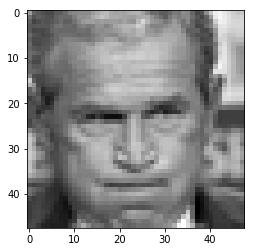

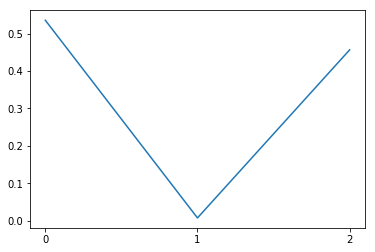

In [224]:
# Show the image of one predicting example
index = np.random.randint(X_predict.shape[0],size=1)
plt.imshow(X_predict[index[0],0,:,:],cmap='gray')

# Get its prediction
output = y_predict[index[0]]
print("Probs: ", output)
print("Class: ", y_result[index[0]])
plt.figure()
plt.xticks(np.arange(output.shape[0]))
plt.plot(np.arange(output.shape[0]),output)
